In [85]:
import numpy as np
import sys
import time
import os
import h5py
import os.path as op
import matplotlib.cm as cm
from matplotlib.widgets import Slider, Button, RadioButtons
import matplotlib.pyplot as plt
import array
%matplotlib inline
sys.path.append('..')
from zwatershed import *
from visualization.visualize_funcs import *
from edgelist_methods import *
path_to_folder = '/Users/chandansingh/drive/janelia/conv_net_scripts/'
path_to_data = path_to_folder + 'data/'
from multiprocessing import Pool

# -------------------------------- parameters ---------------------------------------
# pred_file = '/groups/turaga/home/turagas/research/caffe_v2/processed/bock2/120000/sample_A_x1_y1_z1_xy1.h5'
# pred_file_2 = '/groups/turaga/home/turagas/research/caffe_v2/processed/bock2/120000/cutout_3k.h5'
pred_file = '/groups/turaga/home/turagas/turagalab/FROM_TIER2/singhc/train/output_200000/tstvol-1_2.h5'
gt_seg = '/groups/turaga/home/turagas/data/FlyEM/fibsem_medulla_7col/tstvol-520-1-h5/groundtruth_seg_thick.h5'
gt_aff = '/groups/turaga/home/turagas/data/FlyEM/fibsem_medulla_7col/tstvol-520-1-h5/groundtruth_aff.h5'
out_folder = '/nobackup/turaga/singhc/par_zwshed/'
threshes = [100,2000,100000]
cmap = matplotlib.colors.ListedColormap(np.vstack(((0, 0, 0), np.random.rand(255, 3))))
NUM_WORKERS = 8
MAX_LEN = 400

# -------------------------------- load data ---------------------------------------
f = h5py.File(pred_file, 'r')
preds = f['main']
g = h5py.File(gt_seg,'r')
gt_seg = g['main']
print preds.shape

(3, 432, 432, 432)


# Divide Volumes, set up args

In [93]:
def dim_to_name(start):
    return str(start[0])+'_'+str(start[1])+'_'+str(start[2])+'_vl/'
dims = np.array(preds.shape[1:])
print "dims",dims # x,y,z
num_vols = np.array([int(x/MAX_LEN)+1 for x in dims])
# num_vols[0] = 2 # delete this!
deltas = dims/num_vols
print "num_vols",num_vols
print "deltas",deltas
starts,ends = [],[]
for x in range(num_vols[0]):
    for y in range(num_vols[1]):
        for z in range(num_vols[2]):
            starts.append((x,y,z)*deltas)
            extra = 3*np.array([x==num_vols[0]-1,y==num_vols[1]-1,z==num_vols[2]-1],dtype='int')
            ends.append((x,y,z)*deltas + deltas + [1,1,1]+extra)
args = []
for i in range(len(starts)):
    s,e = starts[i],ends[i]
    pred_vol = preds[:,s[0]:e[0],s[1]:e[1],s[2]:e[2]]
    print i,s,e,pred_vol.shape
    args.append((pred_vol,threshes,out_folder+dim_to_name(s)))    

dims [432 432 432]
num_vols [2 2 2]
deltas [216 216 216]
0 [0 0 0] [217 217 217] (3, 217, 217, 217)
1 [  0   0 216] [217 217 436] (3, 217, 217, 216)
2 [  0 216   0] [217 436 217] (3, 217, 216, 217)
3 [  0 216 216] [217 436 436] (3, 217, 216, 216)
4 [216   0   0] [436 217 217] (3, 216, 217, 217)
5 [216   0 216] [436 217 436] (3, 216, 217, 216)
6 [216 216   0] [436 436 217] (3, 216, 216, 217)
7 [216 216 216] [436 436 436] (3, 216, 216, 216)


# Call Watershed

In [67]:
def zwshed_h5_par(arg):
    (pred_vol,threshes,seg_save_path) = arg
    zwatershed_h5(pred_vol, threshes,seg_save_path)
    print "finished",seg_save_path,"watershed"
p = Pool(NUM_WORKERS)
p.map(zwshed_h5_par, args)

finished /nobackup/turaga/singhc/par_zwshed/0_0_0_vl/ watershed
finished /nobackup/turaga/singhc/par_zwshed/0_216_0_vl/ watershed
finished /nobackup/turaga/singhc/par_zwshed/0_0_216_vl/ watershed
finished /nobackup/turaga/singhc/par_zwshed/0_216_216_vl/ watershed
finished /nobackup/turaga/singhc/par_zwshed/216_0_216_vl/ watershed
finished /nobackup/turaga/singhc/par_zwshed/216_0_0_vl/ watershed
finished /nobackup/turaga/singhc/par_zwshed/216_216_216_vl/ watershed
finished /nobackup/turaga/singhc/par_zwshed/216_216_0_vl/ watershed


[None, None, None, None, None, None, None, None]

# Stitch

	i,x,y,z 6 1 1 0
	shapes (216, 216, 432) (216, 216, 217)
	i,x,y,z 7 1 1 1
	shapes (216, 216, 432) (216, 216, 216)
merging numbers, 144 keys ... 
	before nsegs= 5153 min= 1 num0= 0


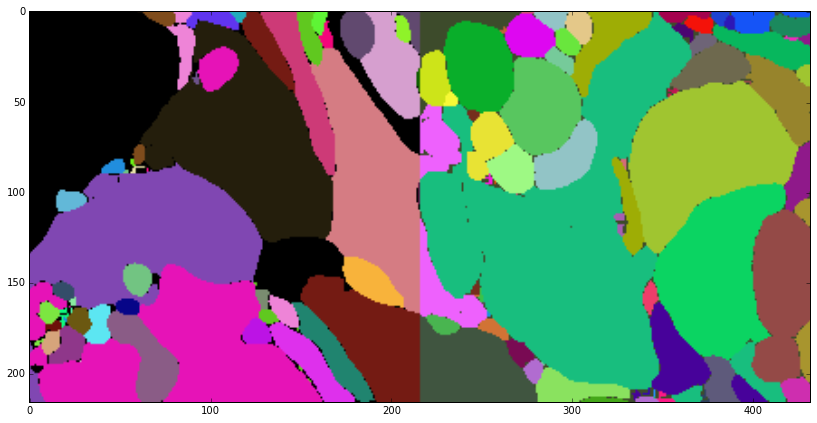

	after nsegs= 5009 min= 1 num0= 0


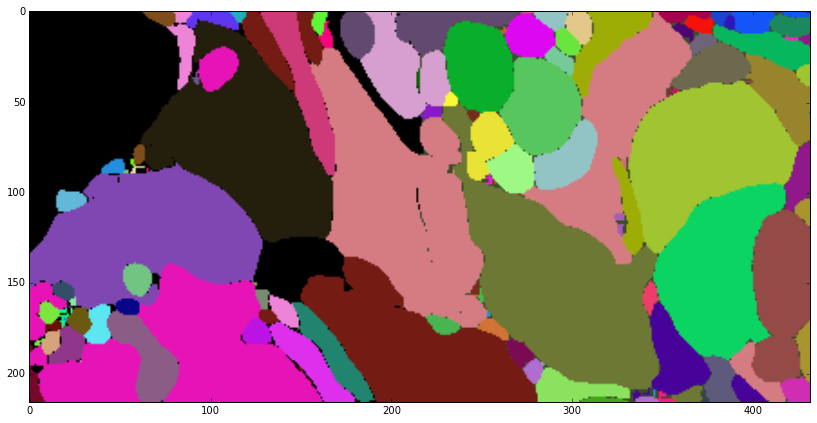

	renumbering all... 5153
	renumbered nsegs= 5009 min= 0


/groups/turaga/home/singhc/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/groups/turaga/home/singhc/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.


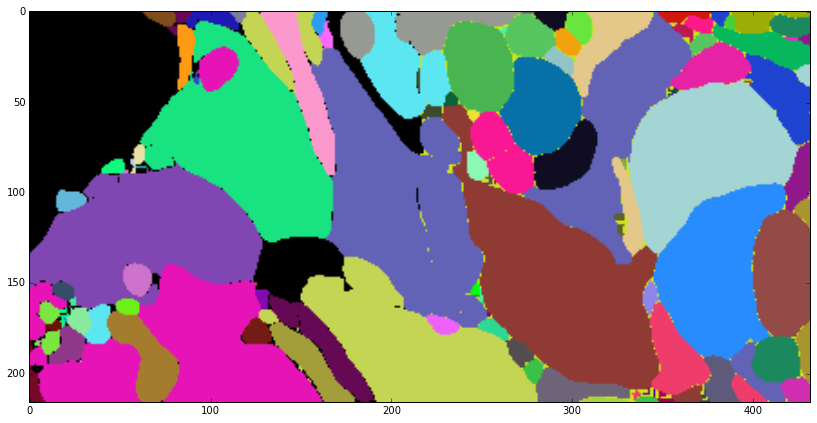

/groups/turaga/home/singhc/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:49: DeprecationWarning: Implicitly casting between incompatible kinds. In a future numpy release, this will raise an error. Use casting="unsafe" if this is intentional.


"        \n        if y==0: # don't merge\n            ybar[:,sy[1]:ey[1],:] = zbar[:,:,:]\n        else: # merge\n            edge_mins = ybar[:,s[1],:].flatten()\n            edge_maxes = zbar[:,0,:].flatten()\n            re_y = calc_renums(edge_mins,edge_maxes, re_y)\n            ybar[:,sy[1]:ey[1],:] = zbar[:,:,:]\n    ybar = merge_and_renum(re_y,ybar,inc=True,p=True)\n    display_seg_yz(ybar,1)\n    # end ybar -------------------------------------------------------\n    if x==0: # don't merge\n        seg_out[sx[0]:ex[0],:,:] = ybar[:,:,:]\n    else: # merge\n        edge_mins = seg_out[sx[0],:,:].flatten()\n        edge_maxes = ybar[0,:,:].flatten()\n        re_x = calc_renums(edge_mins,edge_maxes,re_x)\n        seg_out[sx[0]:ex[0],:,:] = ybar[:,:,:]\nseg_out = merge_and_renum(re_x,seg_out,inc=False)\ndisplay_seg_xy(seg_out)\n"

In [96]:
# todo - have this support several threshes - for filename in os.listdir(arg[2]):
i = 0
seg_out = np.zeros(dims,dtype='uint64')
re_x = {}
backs = [0]
for x in range(1,2): #num_vols[0]):
    i = x*num_vols[1]*num_vols[2]
    sx,ex = starts[i],ends[i]
    
    # start ybar --------------------------------------------------
    xdim = deltas[0]+1
    if x==num_vols[0]-1:
        xdim = dims[0]-deltas[0]*(num_vols[0]-1)
    ybar = np.zeros((xdim,dims[1],dims[2]),dtype='uint64')
    re_y = {}
    for y in range(1,2): #num_vols[1]):
        i = x*num_vols[1]*num_vols[2]+y*num_vols[2]
        sy,ey = starts[i], ends[i]
        
        # start zbar -----------------------------------------------
        ydim = deltas[1]+1
        if y==num_vols[1]-1:
            ydim = dims[1]-deltas[1]*(num_vols[1]-1)
        zbar = np.zeros((xdim,ydim,dims[2]),dtype='uint64')
        re_z = {} # maxes -> mins
        for z in range(2): #num_vols[2]):  # merge along z axis - fills in zbar
            i = x*num_vols[1]*num_vols[2]+y*num_vols[2]+z
            arg,s,e = args[i],starts[i],ends[i]
            filename = 'seg_2000.h5'
            seg_h5 = h5py.File(arg[2]+filename,'r')
            seg = seg_h5['main']+np.max(zbar)+1
            backs.append(np.max(zbar)+1)
            print "\ti,x,y,z",i,x,y,z
            print "\tshapes",zbar.shape,seg.shape
            if z==0: # don't merge
                zbar[:,:,s[2]:e[2]] = seg[:,:,:]
            else: # merge
                edge_mins = zbar[:,:,s[2]].flatten()
                edge_maxes = seg[:,:,0].flatten()                
                re_z = calc_renums(edge_mins,edge_maxes, re_z, backs)
                zbar[:,:,s[2]:e[2]] = seg[:,:,:]
        zbar = merge_and_renum(re_z,zbar,inc=True,p=True)
        # end zbar --------------------------------------------------
        
'''        
        if y==0: # don't merge
            ybar[:,sy[1]:ey[1],:] = zbar[:,:,:]
        else: # merge
            edge_mins = ybar[:,s[1],:].flatten()
            edge_maxes = zbar[:,0,:].flatten()
            re_y = calc_renums(edge_mins,edge_maxes, re_y)
            ybar[:,sy[1]:ey[1],:] = zbar[:,:,:]
    ybar = merge_and_renum(re_y,ybar,inc=True,p=True)
    display_seg_yz(ybar,1)
    # end ybar -------------------------------------------------------
    if x==0: # don't merge
        seg_out[sx[0]:ex[0],:,:] = ybar[:,:,:]
    else: # merge
        edge_mins = seg_out[sx[0],:,:].flatten()
        edge_maxes = ybar[0,:,:].flatten()
        re_x = calc_renums(edge_mins,edge_maxes,re_x)
        seg_out[sx[0]:ex[0],:,:] = ybar[:,:,:]
seg_out = merge_and_renum(re_x,seg_out,inc=False)
display_seg_xy(seg_out)
'''

In [82]:
# stitch methods
def calc_renums(edge_mins,edge_maxes, renums, backs):
    for j in range(len(edge_mins)):
        edge_min = edge_mins[j]
        edge_max = edge_maxes[j]
        if not edge_min in backs and not edge_max in backs:
            if not edge_max==edge_min:
                if edge_max in renums: # already in map
                    old_min = renums[edge_max]
                    merge_max = max(old_min,edge_min)
                    merge_min = min(old_min,edge_min)
                    if not merge_max==merge_min:
                        renums[merge_max] = merge_min  
            renums[edge_max] = edge_min
    return renums
    
def merge_and_renum(renums,zbar,inc=True,p=False):
    # merge numbers
    renums2 = {}
    print "merging numbers,",len(renums.keys()),"keys ... "            
    for key in renums:
        val = renums[key]
        while val in renums:
            val = renums[val]
        renums2[key] = val

    print "\tbefore nsegs=",len(np.unique(zbar)),"min=",np.min(zbar),"num0=",np.sum(zbar==0)
    if p:
#         display_seg_yz(zbar,1)
        display_seg_yz(zbar,5)
    
    mp = np.arange(0,np.max(zbar)+1,dtype='uint64')
    mp[renums2.keys()] = renums2.values()
    zbar = mp[zbar]
    print "\tafter nsegs=",len(np.unique(zbar)),"min=",np.min(zbar),"num0=",np.sum(zbar==0)
    if p:
#         display_seg_yz(zbar,1)
        display_seg_yz(zbar,5)

    # renumber all
    print "\trenumbering all...",np.max(zbar)
    zbar,seg_sizes = prune_and_renum(zbar,2)
    print "\trenumbered nsegs=",len(np.unique(zbar)),"min=",np.min(zbar)
    if p:
#         display_seg_yz(zbar,1)
        display_seg_yz(zbar,5)
    
    if inc:
        zbar += np.max(zbar)+1
    return zbar

# Visualize

In [80]:
def display_affs(raw):
    plt.imshow(np.transpose(raw[:, :, :, 1],(2,1,0)))
    plt.show()
def display_seg_yz(raw,depth=1):
    fig = plt.figure(figsize=(15, 7))
    plt.imshow(raw[depth, :, :], cmap=cmap)
    plt.show()
def display_seg_xy(raw,depth=1):
    fig = plt.figure(figsize=(15, 7))
    ax1 = fig.add_subplot(1, 1, 1)
    fig.subplots_adjust(left=0.2, bottom=0.25)
    ax1.imshow(raw[:, :, depth], cmap=cmap)
    plt.show()
def prune_and_renum(seg,sizeThreshold=1):
    segId,segSizes = np.unique(seg, return_counts=True)
    renum = np.zeros(segId.max()+1,dtype='uint64')
    renum[segId] = np.arange(0,len(segId)+1)
    if sizeThreshold>0:
        renum[segId[segSizes<=sizeThreshold]] = 0
        segSizes = segSizes[segSizes>sizeThreshold]
    seg = renum[seg]
    return (seg, segSizes)

(3, 125, 300, 300)
preds0
0.999997
0.000641769
0.734931
1.0
0.058145
0.860175
1.0
0.124801
0.86506
(125, 300, 300, 3)
(125, 313, 314)


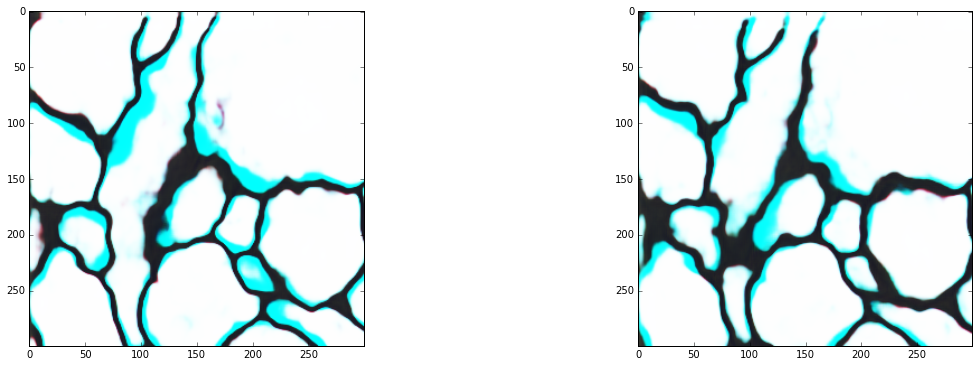

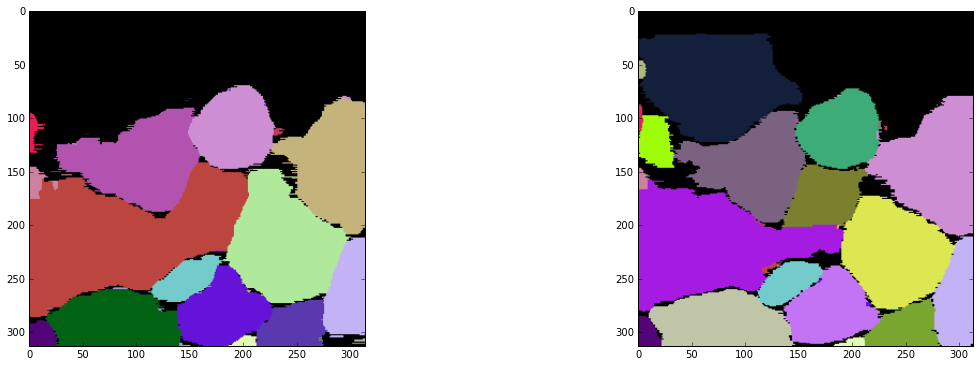

In [27]:
# display_affs(preds,preds,preds)
p_small = preds[:300,:300,:300,:300]
print p_small.shape
preds0 = p_small[0,:,:,:]
print "preds0"
print np.max(preds0)
print np.min(preds0)
print np.average(preds0)
preds1 = p_small[1,:,:,:]
print np.max(preds1)
print np.min(preds1)
print np.average(preds1)
preds2 = p_small[2,:,:,:]
print np.max(preds2)
print np.min(preds2)
print np.average(preds2)
raw = np.transpose(p_small,(1,2,3,0))
print raw.shape
# seg = zwatershed(p_small,[2000])[0]
print seg.shape
fig = plt.figure(figsize=(20, 6))
plt.subplot(1,2,1)
plt.imshow(raw[50, :, :, :])
plt.subplot(1,2,2)
plt.imshow(raw[51, :, :, :])
plt.show()
fig = plt.figure(figsize=(20, 6))
plt.subplot(1,2,1)
plt.imshow(seg[50, :, :],cmap=cmap)
plt.subplot(1,2,2)
plt.imshow(seg[51, :, :],cmap=cmap)
plt.show()

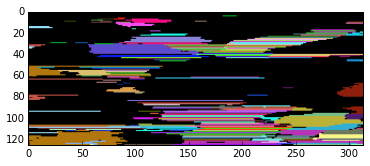

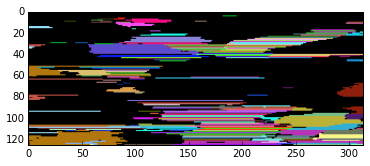

In [65]:
plt.imshow(seg[:, 50, :],cmap=cmap)
plt.show()
plt.imshow(seg[:,50, :],cmap=cmap)
plt.show()

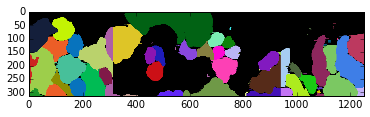

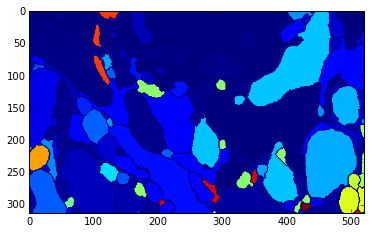

In [31]:
plt.imshow(zbar[1,:,:],cmap=cmap)
plt.show()
plt.imshow(gt_seg[1,:zbar.shape[1],:zbar.shape[2]])